# COVID-19 in Australia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span><ul class="toc-item"><li><span><a href="#other-useful-information" data-toc-modified-id="other-useful-information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>other useful information</a></span></li></ul></li><li><span><a href="#Scrape-Australian-cumulative-data-from-Wikipedia" data-toc-modified-id="Scrape-Australian-cumulative-data-from-Wikipedia-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scrape Australian cumulative data from Wikipedia</a></span></li><li><span><a href="#Produce-a-semilog-plot-of-cases-by-states." data-toc-modified-id="Produce-a-semilog-plot-of-cases-by-states.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Produce a semilog plot of cases by states.</a></span></li><li><span><a href="#Total-bar-charts---most-recent-day" data-toc-modified-id="Total-bar-charts---most-recent-day-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Total bar charts - most recent day</a></span><ul class="toc-item"><li><span><a href="#bar-chart---cumulative-cases" data-toc-modified-id="bar-chart---cumulative-cases-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>bar chart - cumulative cases</a></span></li><li><span><a href="#bar-chart---cumulative-cases-per-capita" data-toc-modified-id="bar-chart---cumulative-cases-per-capita-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>bar chart - cumulative cases per capita</a></span></li></ul></li><li><span><a href="#Chart-new-and-cumulative-cases" data-toc-modified-id="Chart-new-and-cumulative-cases-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Chart new and cumulative cases</a></span></li><li><span><a href="#Plot-new-cases:-raw-and-smoothed" data-toc-modified-id="Plot-new-cases:-raw-and-smoothed-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot new cases: raw and smoothed</a></span></li><li><span><a href="#Growth-factor" data-toc-modified-id="Growth-factor-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Growth factor</a></span></li><li><span><a href="#Regional-per-capita" data-toc-modified-id="Regional-per-capita-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Regional per capita</a></span></li><li><span><a href="#Recent" data-toc-modified-id="Recent-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Recent</a></span></li><li><span><a href="#Bring-it-all-together" data-toc-modified-id="Bring-it-all-together-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Bring it all together</a></span></li></ul></div>

## Python set-up

In [1]:
# imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib.units as munits
import datetime
from pathlib import Path



#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# scraping
import datetime
import requests
from bs4 import BeautifulSoup

# local imports
sys.path.append(r'../bin')
import plotstuff as ps

# plotting
plt.style.use('ggplot')
%matplotlib inline

### other useful information

In [2]:
# state information
colors = ['#ef4444', '#faa31b', '#eee000', '#82c341',
          '#009f75', 'dodgerblue', '#394ba0', '#d54799']   # '#88c6ed', 

AUSTRALIA = 'Australia'
state_pop = {
    # source: https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/3101.0Main%20Features3Sep%202019?opendocument&tabname=Summary&prodno=3101.0&issue=Sep%202019&num=&view=
    'NSW': 8_118_000,
    'VIC': 6_629_900,
    'QLD': 5_115_500,
    'SA':  1_756_500,
    'WA':  2_630_600,
    'TAS':   535_500,
    'NT':    245_600,
    'ACT':   428_100
}
N_STATES = len(state_pop)
state_pop = pd.Series(state_pop).sort_values()
state_names = state_pop.index.to_list()[::-1]
state_pop[AUSTRALIA] = state_pop.sum()

# save location
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!AS-'

## Scrape Australian cumulative data from Wikipedia

In [3]:
def scrape_wiki_data():
    
    # get cases
    url = 'https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Australia_medical_cases'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.findAll('table')
    for table in tables:
        if table.findParent("table") is None:
            cases = pd.read_html(table.prettify(), header=0, index_col=0)[0]
            break
            
    # get deaths
    url = 'https://en.wikipedia.org/wiki/Template:COVID-19 pandemic data/Australia deaths'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.findAll('table')
    for table in tables:
        if table.findParent("table") is None:
            deaths = pd.read_html(table.prettify(), header=1, index_col=0)[0]
            break

    return cases, deaths

#cases, deaths = scrape_wiki_data()
#print(deaths)

In [4]:
def common_cleaning(df: pd.DataFrame, mode: str) -> pd.DataFrame:
    
    # 5. if the last row is today, 
    #    delete it as incomplete by definition
    now = datetime.datetime.today().date()
    yesterday = (pd.Timestamp((now - datetime.timedelta(days=1))
                           .strftime('%Y-%m-%d'))
                )
    today = now.strftime('%-d %B')
    year = now.strftime('%Y')
    if df.index[-1] == today:
        df = df.iloc[:-1]
    
    # 6. make numeric
    df = df.astype(float)

    # 7. make the index a DatetimeIndex
    #    expand to all days
    df.index = pd.DatetimeIndex(df.index + year, dayfirst=True).date
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx, fill_value=np.nan)
    df = df.where(df > 0, other=np.nan).ffill().fillna(0)#.astype(int)
    
    # reindex (to PeriodIndex)
    idx = pd.date_range(df.index.min(), yesterday)
    df = df.reindex(idx, fill_value=np.nan).ffill()
    
    # 8. make sure it is in date order
    df = df.sort_index()

    # --- save it, just to be sure - you never know 
    #     when Wikipedia will stop making this available
    SAVE_DIRECTORY = '../saved_AU_data'
    Path(SAVE_DIRECTORY).mkdir(parents=True, exist_ok=True)
    for_saving = df.copy()
    filename = f'{SAVE_DIRECTORY}/Australia-{mode}-{today}.csv'
    for_saving.to_csv(filename)
    
    return df

In [5]:
def clean_wiki_cases(df):    
    # --- clean-up what we scraped - very tedious
    #     as this table is very messy - fragile
    #     as Wikipedia constantly changes its layout
    #     and format.

    # 1. get rid of footnotes from column names, etc.
    df.columns = (df.columns.str.replace('\[.*\]', '')
                  .str.replace('  ', ' ')
                  .str.strip())
    df.index = df.index.str.replace('\[.*\]', '')

    # 2. remove nan and other rows
    df = df[df.index.notna()]
    df = df[df.index.str.contains('[0-9]')] # not dates
    df = df[~df.index.str.contains('Values')]
    df = df[~df.index.str.contains('Notes')]


    # 3. remove footnotes from specified columns
    if 'Ref.' in df.columns:
        del df['Ref.']
    if 'Reference' in df.columns:
        del df['Reference']
    for c in df.columns:
        df[c] = (df[c].str.replace('\[.*\]', '').str.strip())
        df[c] = df[c].str.replace(',', '')

    # 4. remove '%' text from specified columns
    cols = ['% growth']
    for c in cols:
        df[c] = (df[c].str.replace('\%', '')
                 .str.strip().astype(float))

    df = common_cleaning(df, 'cases')
    
    return df

In [6]:
def clean_wiki_deaths(df):
    
    # 1. delete reference column
    if 'Ref.' in df.columns:
        del df['Ref.']
    if 'Reference' in df.columns:
        del df['Reference']
    
    # 2. remove nan and other rows
    df = df[df.index.notna()]
    df = df[df.index.str.contains('[0-9]')] # not dates

    df = common_cleaning(df, 'deaths')

    return df

In [7]:
def scrape_and_clean_data():
    cases, deaths = scrape_wiki_data()
    cases = clean_wiki_cases(cases)
    deaths = clean_wiki_deaths(deaths)
    
    return cases, deaths

## Produce a semilog plot of cases by states. 

In [8]:
def semilog_plot(states_data, mode):
    
    power = 5
    pop_factor = int(10 ** power)
    #state_names = states_data.columns
    dates = states_data.index
    states_data.index = range(len(dates))

    for per_capita in [False, True]:
        
        if per_capita:
            states_data = states_data / state_pop * pop_factor
            states_data = states_data[state_names]
            title = f'/$10^{power}$ pop.'
            filename = '-per-capita'
            
        else:
            title = ''
            filename= ''
    
        # canvas size
        ymaxmax = states_data.max().max()
        yspace = ymaxmax * 0.2 # may need adjusting
        ylim = (1, ymaxmax+yspace)
        if per_capita:
            ylim = (0.1, ymaxmax+yspace)
        xmaxmax = len(states_data) - 1
        xspace = xmaxmax * 0.02
        xlim = (-xspace, xmaxmax+xspace)
    
        ax = plt.subplot(xlim=xlim, ylim=ylim)
        for i, name in enumerate(states_data.columns):
            states_data[name].plot(lw=2, color=colors[i], label=name, ax=ax)

        ax.set_title(f'COVID19 Cumulative {mode.title()}{title}: Australian States')
        ax.set_xlabel('Date')
        ax.set_ylabel(f'{mode.title()}{title} (log scale)')
        ax.set_yscale('log')
        ax.legend(loc='upper left')

        fig = ax.figure
        fig.set_size_inches(8, 4)
        fig.text(0.99, 0.01, 'Source: Wikipedia',
            ha='right', va='bottom',
            fontsize=9, fontstyle='italic',
           color='#999999')
        fig.tight_layout(pad=1)

        labels = [item.get_text() for item in ax.get_xticklabels()]
        for i, text in enumerate(labels):
            if not text:
                continue
            day = int(text.replace('−', '-'))
            if day < 0 or day >= len(dates):
                labels[i] = ''
            else:
                labels[i] = f'{dates[day].day}/{dates[day].month}'
        ax.set_xticklabels(labels)
        fig.tight_layout(pad=1)

        fig.savefig(f'{CHART_DIRECTORY}semilog-trajectory-{mode}{filename}.png', dpi=125)
        plt.show()  
        plt.close()

## Total bar charts - most recent day

### bar chart - cumulative cases

In [9]:
def bar_chart_cumulative(states_data, mode):
    states_data[AUSTRALIA] = states_data.sum(axis=1)
    latest = states_data.iloc[-1]
    date = states_data.index[-1].ctime()[:10]
    latest = latest.sort_values()
    ps.plot_barh(latest, 
        title=f'COVID19 Cumulative {mode}: Australian States',
        savefig = f'{CHART_DIRECTORY}bar-chart-cumulative-{mode}.png',
        rfooter='Source: Wikipedia ' + date
    )
    return latest

### bar chart - cumulative cases per capita

In [10]:
def bar_chart_cum_per_capita(latest, mode):
    power = 5
    pop_factor = int(10 ** power)
    latest = (latest / state_pop) * pop_factor
    latest = latest[state_pop.index].round(2) # pop order
    ps.plot_barh(latest, 
             title=f'COVID19 Cumulative {mode.title()} /'+
                 f' $10^{power}$ pop.: Australian States',
             savefig = f'{CHART_DIRECTORY}bar-chart-per-capita-cumulative-{mode}.png',
             rfooter='Source: Wikipedia'
    )

## Chart new and cumulative cases

In [11]:
def plot_new_and_cum_cases(states_new, states_cum, mode, lfooter=''):
    states_cum = states_cum.T
    previous = states_cum.columns.min() - pd.DateOffset(days=1)
    states_cum[previous] = 0
    states_cum = states_cum.T.sort_index()

    for name in states_cum.columns:
        ps.plot_new_cum(
            states_new[name], states_cum[name], mode, name, 
            title=f'COVID-19 {mode.title()}: {name}',
            rfooter='Source: Wikipedia',
            lfooter=lfooter,
            savefig=f'{CHART_DIRECTORY}'+
                f'new-vs-cum-{mode}-{name}-{lfooter}.png'
        )    


## Plot new cases: raw and smoothed

In [12]:
def plot_new_original_smoothed(states_new, mode):
    HMA = 15
    smooth_all = pd.DataFrame()
    rolling_all = pd.DataFrame()
    for name in states_new.columns:
        smooth_all[name] = ps.plot_orig_smooth(states_new[name], 
            HMA, 
            mode,
            'Australia', 
            title=f'Covid19: {name} (new {mode} per day)', 
            ylabel=f'New {mode} per day',
            tight=1.25,
            rfooter='Source: Wikipedia',
            #lfooter=f'Smoother: {HMA}-term Henderson moving average',
            savefig=f'{CHART_DIRECTORY}new-{mode}-chart-{name}.png'

        )
        rolling_all[name] = states_new[name].rolling(7).mean()

    # latest per-captia comparison 
    power = 5
    pop_factor = int(10 ** power)
    latest = rolling_all.iloc[-1]  
    latest = (latest / state_pop) * pop_factor
    latest = latest[state_pop.index].round(2) # pop order
    ps.plot_barh(latest,
        title=f'COVID19 Daily New {mode.title()} (7 day average) / $10^{power}$ population',
        savefig=f'{CHART_DIRECTORY}bar-chart-per-capita-new-{mode}.png',
        rfooter='Source: Wikipedia'
    )

## Growth factor

In [13]:
def plot_growth_factor(states_new, mode):
    for name in states_new.columns:
        ps.plot_growth_factor(states_new[name], 
            title=f'{name}: weekly growth - new COVID-19 {mode.lower()}',
            ylabel='Growth factor',
            xlabel=None,
            figsize=(8, 4),
            savefig=f'{CHART_DIRECTORY}growth-chart-{name}-{mode}.png',
            rfooter='Source: Wikipedia',
            lfooter=f'Weekly rolling average daily new {mode.lower()} this week / last week'
        )

## Regional per capita

In [14]:
def regional(df, mode):

    if 'Total' in df:
        del df['Total']
        
    regions = {
        'Australia': ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT'],
    }
    
    #old = plt.rcParams['axes.prop_cycle'].by_key()['color']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
    
    ps.plot_regional_per_captia(df[regions['Australia']], mode, regions, state_pop, 
        rfooter='Source: Wikipedia',
        tight=1,
        savefig_prefix=CHART_DIRECTORY
    )

## Recent

In [15]:
def recent(df, mode):
    RECENT = 42 # days
    MA1 = 7 # days
    MA2 = 14 # dats
    plt.style.use('ggplot')
    
    for col in df.columns:
        series = df[col]
        
        if series.iloc[-RECENT:].sum() <= 0: 
            continue
        ma1 = series.rolling(MA1).mean()
        ma2 = series.rolling(MA2).mean()
        
        MARGINS = 0.01
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(MARGINS) # seems to work here
        
        #series.iloc[-RECENT:].plot.
        ax.bar(series.iloc[-RECENT:].index.values, series.iloc[-RECENT:], label=mode, color='#dd0000')
        ax.plot(ma1.iloc[-RECENT:].index.values, ma1.iloc[-RECENT:], label=f'{MA1} day ave.', color='darkorange')
        ax.plot(ma2.iloc[-RECENT:].index.values, ma2.iloc[-RECENT:], label=f'{MA2} day ave.', color='cornflowerblue')

        title = f'COVID19 Recent {mode.title()} in {col} '
        ax.set_title(title)
        ax.set_ylabel(f'Daily New {mode.title()}')
        ax.legend(loc='best')

        fig = ax.figure
        fig.set_size_inches(8, 4)
        fig.text(0.99, 0.01, 'Source: Wikipedia',
            ha='right', va='bottom',
            fontsize=9, fontstyle='italic',
           color='#999999')
        fig.tight_layout(pad=1)

        fig.savefig(f'{CHART_DIRECTORY}{title}.png', dpi=125)
        plt.show()
        plt.close()

## Bring it all together

NSW           4645.00
VIC          20352.00
QLD           1227.00
WA             837.00
SA             563.00
TAS            234.00
ACT            117.00
NT              64.00
Total        28039.00
New cases        8.00
% growth         0.03
Name: 2020-12-14 00:00:00, dtype: float64
Negatives in NSW
2020-04-12   -3.0
2020-05-04   -2.0
2020-05-27   -3.0
2020-06-07   -1.0
2020-06-12   -1.0
2020-06-23   -1.0
2020-11-13   -1.0
Name: NSW, dtype: float64
Spikes in NSW
       2020-07-03
spike  189.000000
mean     8.285714
zeros    0.000000
Negatives in VIC
2020-10-18   -2.0
2020-10-26   -2.0
2020-11-01   -1.0
2020-11-02   -1.0
Name: VIC, dtype: float64
Negatives in QLD
2020-04-30   -1.0
2020-05-25   -3.0
2020-08-07   -1.0
2020-08-15   -1.0
2020-09-16   -1.0
2020-10-31   -1.0
Name: QLD, dtype: float64
Negatives in WA
2020-05-12    -1.0
2020-08-06   -28.0
Name: WA, dtype: float64
Negatives in SA
2020-11-19   -1.0
Name: SA, dtype: float64
Negatives in TAS
2020-04-05   -1.0
Name: TAS, dtype: floa

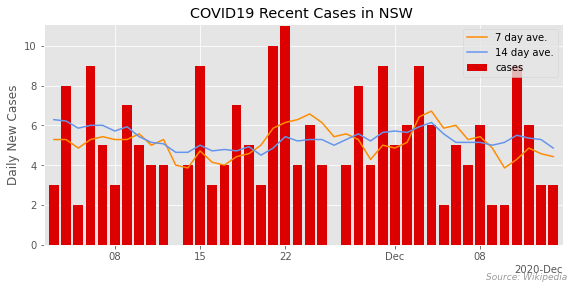

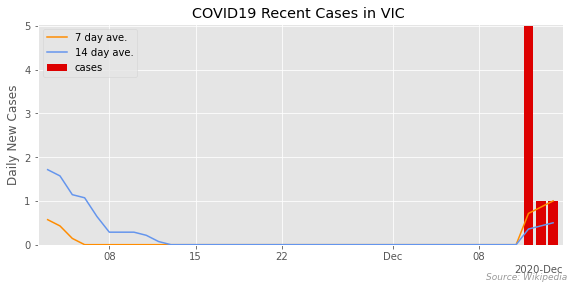

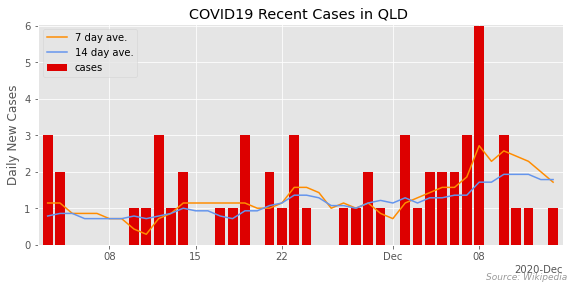

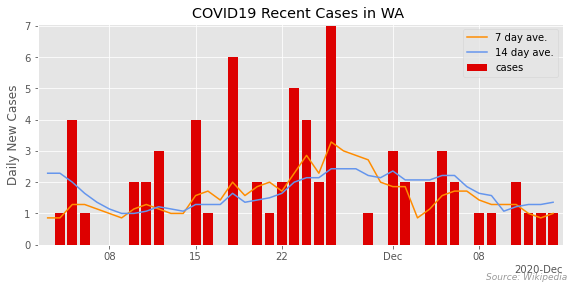

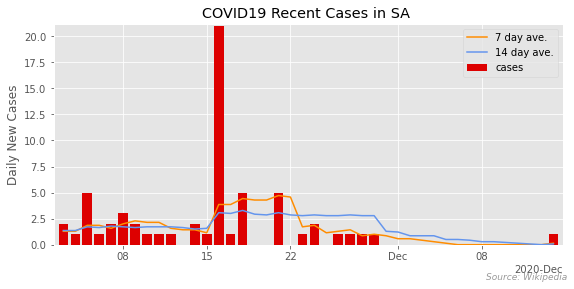

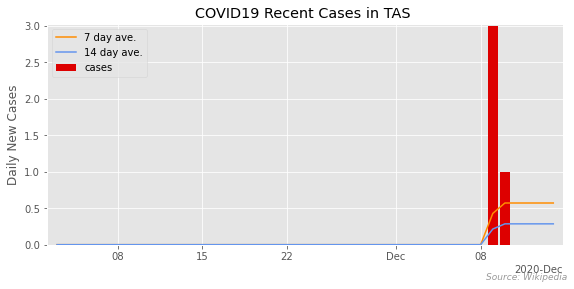

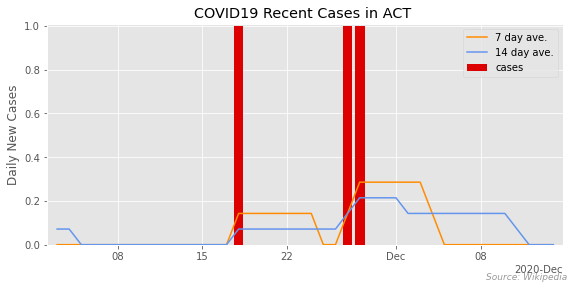

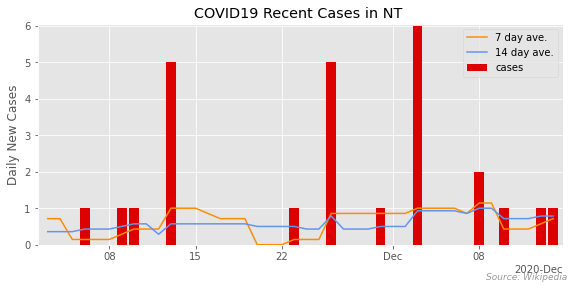

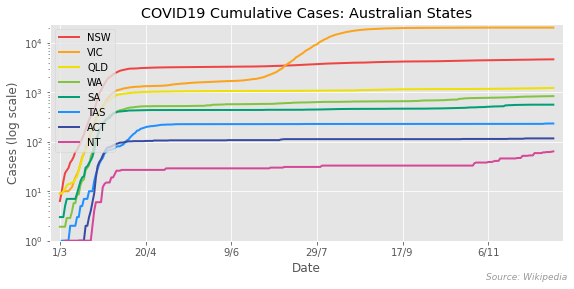

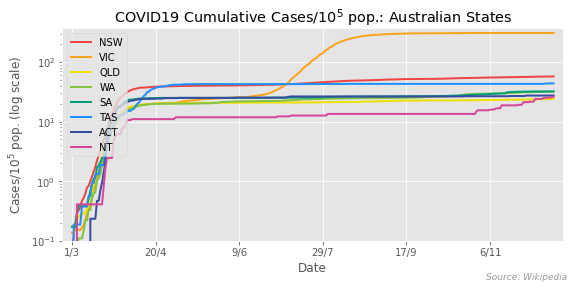

Last week (uncorrected daily new):


,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
2020-11-24,6.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0
2020-11-25,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-11-26,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0
2020-11-27,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2020-11-28,8.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2020-11-29,4.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
2020-11-30,9.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-12-01,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2020-12-02,6.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
2020-12-03,9.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0


Data too sparse in NSW (max_consecutive=4)
Data too sparse in QLD (max_consecutive=1)
Data too sparse in WA (max_consecutive=2)
Data too sparse in SA (max_consecutive=3)
Data too sparse in TAS (max_consecutive=3)
Data too sparse in ACT (max_consecutive=1)
Data too sparse in NT (max_consecutive=0)


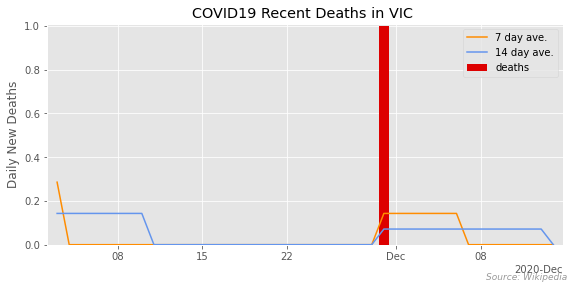

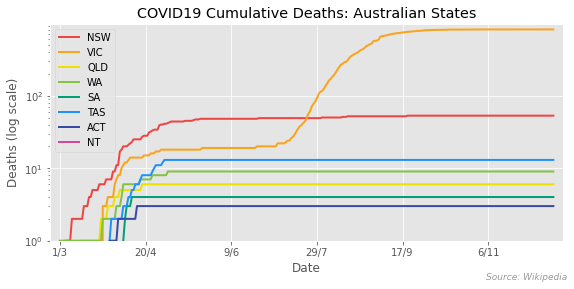

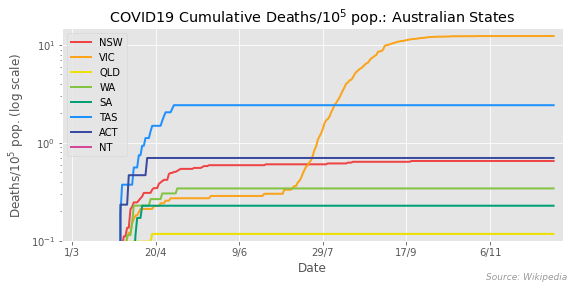

Last week (uncorrected daily new):


,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
2020-11-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
cases, deaths = scrape_and_clean_data()
print(cases.iloc[-1])

modes = ['cases', 'deaths']
data = [cases, deaths]

saved = {}

for mode, uncorrected_cumulative in zip(modes, data):

    # remove extraneous information from web scraping
    uncorrected_cumulative = uncorrected_cumulative[
        uncorrected_cumulative.columns[0:N_STATES]]
    
    
    # save national for later
    saved[mode] =  uncorrected_cumulative.sum(axis=1)
  
    # data transformation - correct for data glitches
    (uncorrected_daily_new, 
         corrected_daily_new, 
         corrected_cumulative) = ps.dataframe_correction(uncorrected_cumulative)
    
    #if(mode == 'deaths'):
    #    print('='*40)
    #    print(uncorrected_cumulative['WA'])
    #    print(corrected_cumulative['WA'])
    #    print('='*40)

    # recent
    recent(corrected_daily_new.copy(), mode)
    
    # regional line plota
    regional(corrected_daily_new.copy(), mode)
    
    # state trajectories
    states_data = corrected_cumulative.copy()
    START_DATE = pd.Timestamp('2020-03-01')
    states_data = states_data[states_data.index >= START_DATE]
    semilog_plot(states_data, mode)

    # bar charts cumulative cases - current status
    states_data = uncorrected_cumulative.copy().astype(int)
    latest = bar_chart_cumulative(states_data, mode)
    bar_chart_cum_per_capita(latest, mode)

    # New and cumulative cases
    states_cum = corrected_cumulative.copy()
    states_cum[AUSTRALIA] = states_cum.sum(axis=1)
    states_new = corrected_daily_new.copy()
    states_new[AUSTRALIA] = states_new.sum(axis=1)
    plot_new_and_cum_cases(states_new, states_cum, mode,
                           lfooter='Any extreme outliers have been adjusted')
    plot_new_and_cum_cases(uncorrected_daily_new.copy(), 
                           uncorrected_cumulative.copy(),
                           mode, lfooter='Original data')

    print('Last week (uncorrected daily new):')
    display(uncorrected_daily_new.iloc[-21:])

    # New cases original and smoothed
    plot_new_original_smoothed(states_new.copy(), mode)

    # Growth rates
    plot_growth_factor(states_new.copy(), mode)



In [17]:
# quick comparison of case fatality rates - firat and second Australian waves
point1 = pd.Timestamp('2020-05-31')
p = saved['deaths'].loc[point1], saved['cases'].loc[point1]
print('First wave CFR: ', p[0] / p[1] * 100)
print('Second wave CFR: ', (saved['deaths'].iloc[-1] - p[0]) 
      / (saved['cases'].iloc[-1] - p[1]) * 100)

First wave CFR:  1.417651146629604
Second wave CFR:  3.866820188063711


In [18]:
print('Finished')

Finished
